## Configurations and libraries

**Important note**

Generate the `FER2013+` dataset before running the application


In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from  torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets.FaceAlignedFERPlusDataset import FaceAlignedFERPlusDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import random
import os
from datetime import datetime

device = torch.device("mps" if torch.mps.is_available() else "cpu")

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the checkpoint directory exists

# device = "cpu"
# Paths to dataset directories
train_dir = "./data/FER2013Train"
val_dir = "./data/FER2013Valid"
test_dir = "./data/FER2013Test"

# Paths to labels
train_csv = "./data/FER2013Train/label.csv"
val_csv = "./data/FER2013Valid/label.csv"
test_csv = "./data/FER2013Test/label.csv"

In [2]:
def check_data_availability(image_dir, label_csv):
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist.")
        return False

    png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    if len(png_files) == 0:
        print(f"Error: No .png files found in directory {image_dir}.")
        return False

    # Check if label CSV exists
    if not os.path.exists(label_csv):
        print(f"Error: Label file {label_csv} does not exist.")
        return False

    print(f"Data check passed for {image_dir} and {label_csv}.")
    return True

# Check all directories
if (
    check_data_availability(train_dir, train_csv) and
    check_data_availability(val_dir, val_csv) and
    check_data_availability(test_dir, test_csv)
):
    print("All data is available and ready for training!")
else:
    print("Data check failed. Please fix the errors and try again.")


Data check passed for ./data/FER2013Train and ./data/FER2013Train/label.csv.
Data check passed for ./data/FER2013Valid and ./data/FER2013Valid/label.csv.
Data check passed for ./data/FER2013Test and ./data/FER2013Test/label.csv.
All data is available and ready for training!


## Data Preprocessing

`Challenge:`

What is the proper way to augment dataset?

There are 2 ways to apply augmentation:
* On the fly (when loading custom `Dataset`, pass original image and augmented image)
* Create a separate augmented dataset and combine with original 

`Solution:`

We chose to create a separate dataset and combine it with original one.




In [3]:
# Apply transformations and augmentation
main_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor() ,  
    transforms.Normalize((0.5,), (0.5,), (0.5,),)  
])

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduce rotation degrees
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  # Subtle jitter
    transforms.RandomResizedCrop(size=(40, 40), scale=(0.9, 1.0)),  # Reduce crop range
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_first_dataset = FaceAlignedFERPlusDataset(
    image_dir=train_dir,
    label_csv=train_csv,
    transform=main_transform,
    aug_transform=train_augmentation, 
    mode="majority",
    face_detector="opencv"
)

test_dataset = FaceAlignedFERPlusDataset(
    image_dir=test_dir,
    label_csv=test_csv,
    transform=main_transform,
    aug_transform=None,
    mode="majority",
    face_detector="opencv"
)
validation_dataset = FaceAlignedFERPlusDataset(
    image_dir=val_dir,
    label_csv=val_csv,
    transform=main_transform,
    aug_transform=None, 
    mode="majority",
    face_detector="opencv"
)

# Create data loaders
batch_size = 64  
    
train_loader = DataLoader(train_first_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Debugging a sample
for img, label in train_loader:
    print(f"Image type: {type(img)}, Image shape: {img.shape}")
    break


Image type: <class 'torch.Tensor'>, Image shape: torch.Size([64, 3, 48, 48])


## CNN Architecture
4 blocks:
* Convolutional layer
* Normalization layer
* `ReLU` activation function
* Convolutional layer
* Normalization layer
* `ReLU` activation function
* `Max Pooling` layer

last 5-th block:  
Same as previous. Without Pooling layer

1 dense layer

**Challenge**: Model takes more than `10 minutes` to train   
**Suggested solution**: Decrease the amount of out_channels in convolutional layers and add Normalization.  
**Result**: Model takes `15% less time` compared to previous runs(ran on `cpu`)


In [5]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.6, num_emotions=2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.num_emotions = num_emotions
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 5
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        dummy_input = torch.zeros(1, 3, 48, 48)  # Assuming input image size (3, 48, 48)
        self.flatten_size = self._get_flatten_size(dummy_input)

        self.dense_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=256, out_features=128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=128, out_features=num_emotions)  # Output layer for num_emotions classes
        )
        
    def _get_flatten_size(self, x):
        """Calculate the flatten size dynamically by passing a dummy input."""
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.dense_layer(x)
        return x


## Regularization: Early stopping

In [6]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience # Number of epochs to wait before stopping
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


## Train the model

In [7]:
def early_stopping_triggered(early_stopping, val_loss):
    """Check and handle early stopping condition."""
    early_stopping(val_loss)
    return early_stopping.early_stop

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch and compute metrics."""
    model.train()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Store predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(all_labels, all_predictions)
    train_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return running_loss / len(train_loader), train_accuracy, train_precision, train_recall, train_f1


def validate_model(model, val_loader, criterion, device):
    """Evaluate the model on the validation set and compute metrics."""
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            # Store predictions and labels for metrics
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_predictions)
    val_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    val_recall = recall_score(all_labels, all_predictions, average='weighted')
    val_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss / len(val_loader), val_accuracy, val_precision, val_recall, val_f1


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, early_stopping):
    """Train the model with validation, metrics, and early stopping."""
    
    writer = SummaryWriter(f"runs/model{datetime.now()}")
    training_dir = f"{checkpoint_dir}/training/"
    os.makedirs(training_dir, exist_ok=True)  # Ensure the checkpoint directory exists

    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validation
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(
            model, val_loader, criterion, device
        )

        
        if epoch == num_epochs - 1:
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
        else: 
            print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch + 1)
        writer.add_scalar("Precision/Train", train_precision, epoch + 1)

        # Save model checkpoint
        checkpoint_path = os.path.join(f"{checkpoint_dir}/training/", f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        
        # Early Stopping
        if early_stopping_triggered(early_stopping, val_loss):
            print("Early stopping triggered!")
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
            break
        
        
        


## Run training process

In [8]:
early_stopping = EarlyStopping(patience=8)
model = CNN(dropout_rate=0.4, num_emotions=8).to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-7)

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20,
    early_stopping=early_stopping
)

Epoch 1/20 Train Loss: 1.5664, Val Loss: 1.5996
Epoch 2/20 Train Loss: 1.4382, Val Loss: 1.3858
Epoch 3/20 Train Loss: 1.1785, Val Loss: 1.0124
Epoch 4/20 Train Loss: 0.9949, Val Loss: 0.8572
Epoch 5/20 Train Loss: 0.9269, Val Loss: 0.8147
Epoch 6/20 Train Loss: 0.8816, Val Loss: 0.8062
Epoch 7/20 Train Loss: 0.8203, Val Loss: 0.7356
Epoch 8/20 Train Loss: 0.7843, Val Loss: 0.8066
Epoch 9/20 Train Loss: 0.7483, Val Loss: 0.6920
Epoch 10/20 Train Loss: 0.7092, Val Loss: 0.6505
Epoch 11/20 Train Loss: 0.6875, Val Loss: 0.6419
Epoch 12/20 Train Loss: 0.6703, Val Loss: 0.6109
Epoch 13/20 Train Loss: 0.6385, Val Loss: 0.6681
Epoch 14/20 Train Loss: 0.6245, Val Loss: 0.5838
Epoch 15/20 Train Loss: 0.5970, Val Loss: 0.5675
Epoch 16/20 Train Loss: 0.5771, Val Loss: 0.5410
Epoch 17/20 Train Loss: 0.5701, Val Loss: 0.5646
Epoch 18/20 Train Loss: 0.5531, Val Loss: 0.5027
Epoch 19/20 Train Loss: 0.5253, Val Loss: 0.5307
Train Loss: 0.5144
Train Accuracy: 0.8321
Train Precision 0.8273
Train Recall:

In [13]:
from torchsummary import summary
summary(model.to("cpu"), input_size=(3, 48, 48), device="cpu")

# Move the model back to the MPS device for training
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]           9,248
       BatchNorm2d-5           [-1, 32, 48, 48]              64
              ReLU-6           [-1, 32, 48, 48]               0
         MaxPool2d-7           [-1, 32, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          18,496
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11           [-1, 64, 24, 24]          36,928
      BatchNorm2d-12           [-1, 64, 24, 24]             128
             ReLU-13           [-1, 64, 24, 24]               0
        MaxPool2d-14           [-1, 64,

## Evaluate the model

/Users/kovalski555/PycharmProjects/data_ai_5_dl_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.8133
Test Precision 0.8190
Test Recall: 0.8133
Test F1 score: 0.8031


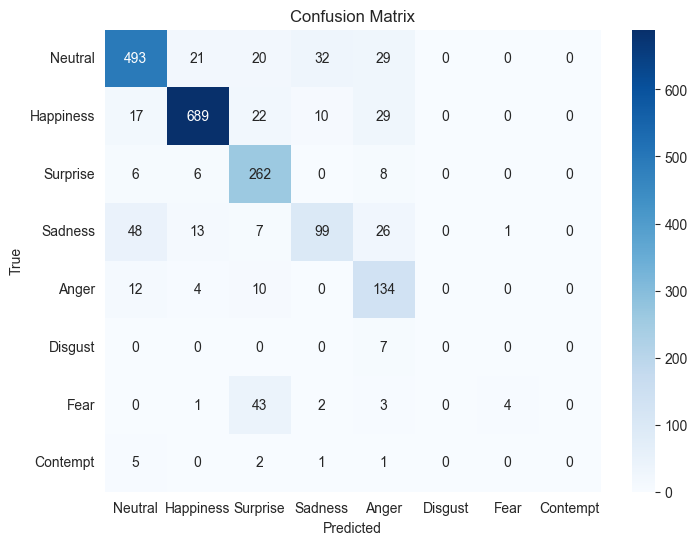

In [10]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    return metrics

metrics = evaluate_model(model, test_loader, device)

emotion_labels = [
    "Neutral", "Happiness", "Surprise", "Sadness", 
    "Anger", "Disgust", "Fear", "Contempt"
]

all_labels = []  # True labels
all_predictions = []  # Model predictions

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Future work recommendation and Interpretation of the results

**Overfitting**: Large gap between training and validation performance.  
**Underfitting**: Both training and validation performances are poor.  
**Good Model**: Training and validation performances are aligned and good.  


### What to do next?

`Addressing Class Imbalance:`  

Use weighted loss functions (e.g., weighted cross-entropy) to penalize misclassification of minority classes more heavily.

`Augmentation Pipeline Enhancements:`  

Add more complex data augmentation techniques such as color jitter, Gaussian blur, or random noise injection to make the model more robust to real-world variability.

# Save the model

In [14]:
os.makedirs("models/", exist_ok=True) 

torch.save(model, "models/model_>80.pth")

## Hyperparameter tuning: Random Search 

`Observed problem:`  

As seen in hyperparameter tuning and just by running the model manually, our team found out  
that model accuracy becomes `worse` if we utilize the `L2 regularization` for Adam Optimizer

`Proposed Solution:` 

Avoid using L2 regularization in basic run

In [11]:
def random_search_with_logging(train_loader, val_loader, num_trials, device, ):
    param_grid = {
        'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3],
        'dropout_rate': [0.3, 0.4, 0.5, 0.6],
        'weight_decay': [1e-5, 1e-4, 1e-3],
        'batch_size': [16, 32, 64, 128]
    }

    random_search_dir = f"{checkpoint_dir}/tuning/"
    os.makedirs(random_search_dir, exist_ok=True) 

    best_val_loss = float('inf')
    best_params = None

    for trial in range(num_trials):

        lr = random.choice(param_grid['learning_rate'])
        dropout_rate = random.choice(param_grid['dropout_rate'])
        weight_decay = random.choice(param_grid['weight_decay'])
        batch_size = random.choice(param_grid['batch_size'])

        print(f"\nTrial {trial + 1}/{num_trials}:")
        print(f"Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Weight Decay: {weight_decay}, Batch Size: {batch_size}")


        ## Apply random hyperparameter values
        train_loader = DataLoader(train_first_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        model = CNN(dropout_rate=dropout_rate, num_emotions=8).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # TensorBoard writer for this trial
        writer = SummaryWriter(log_dir=f"runs/trial_{trial + 1}")

        # Train the model
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_targets).item()

                    _, predicted = torch.max(val_outputs, 1)
                    correct += (predicted == val_targets).sum().item()
                    total += val_targets.size(0)

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            # Log to TensorBoard
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Save checkpoint for the current trial
            torch.save(model.state_dict(), f"{random_search_dir}trial_{trial + 1}_epoch_{epoch + 1}.pth")

        # Update best parameters if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {
                'learning_rate': lr,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'batch_size': batch_size
            }
            print(f"New best parameters found: {best_params}, Val Loss: {best_val_loss:.4f}")

        writer.close()  

    print("\nRandom Search Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return best_params, best_val_loss


def run_with_best_params(best_params, train_loader, val_loader, test_loader, num_epochs, device):
    print("\nTraining with Best Parameters:")
    print(f"Learning Rate: {best_params['learning_rate']}, Dropout Rate: {best_params['dropout_rate']}, "
          f"Weight Decay: {best_params['weight_decay']}, Batch Size: {best_params['batch_size']}")

    # Adjust DataLoaders with the best batch size
    train_loader = DataLoader(train_first_dataset,
                               batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=best_params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    # Initialize model, optimizer, and criterion
    model = CNN(dropout_rate=best_params['dropout_rate'], num_emotions=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    # Early stopping setup
    early_stopping = EarlyStopping(patience=5)

    # Train the model
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        early_stopping=early_stopping
    )

    # Evaluate the model on the test set
    test_metrics = evaluate_model(model, test_loader, device)

    # Plot confusion matrix
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return model, test_metrics


## Run with best parameters


Trial 1/5:
Learning Rate: 0.005, Dropout Rate: 0.6, Weight Decay: 1e-05, Batch Size: 64
Epoch 1/10, Train Loss: 1.5301, Val Loss: 1.4577, Val Accuracy: 0.3964
Epoch 2/10, Train Loss: 1.2367, Val Loss: 0.9972, Val Accuracy: 0.6827
Epoch 3/10, Train Loss: 1.0633, Val Loss: 1.0618, Val Accuracy: 0.6701
Epoch 4/10, Train Loss: 0.9761, Val Loss: 0.8423, Val Accuracy: 0.7274
Epoch 5/10, Train Loss: 0.9220, Val Loss: 0.8238, Val Accuracy: 0.7540
Epoch 6/10, Train Loss: 0.8760, Val Loss: 0.8281, Val Accuracy: 0.7122
Epoch 7/10, Train Loss: 0.8337, Val Loss: 0.7466, Val Accuracy: 0.7588
Epoch 8/10, Train Loss: 0.7977, Val Loss: 0.7251, Val Accuracy: 0.7477
Epoch 9/10, Train Loss: 0.7794, Val Loss: 0.6775, Val Accuracy: 0.7791
Epoch 10/10, Train Loss: 0.7513, Val Loss: 0.6916, Val Accuracy: 0.7758
New best parameters found: {'learning_rate': 0.005, 'dropout_rate': 0.6, 'weight_decay': 1e-05, 'batch_size': 64}, Val Loss: 0.6916

Trial 2/5:
Learning Rate: 0.001, Dropout Rate: 0.3, Weight Decay: 0

/Users/kovalski555/PycharmProjects/data_ai_5_dl_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.7557
Test Precision 0.8176
Test Recall: 0.7557
Test F1 score: 0.7628


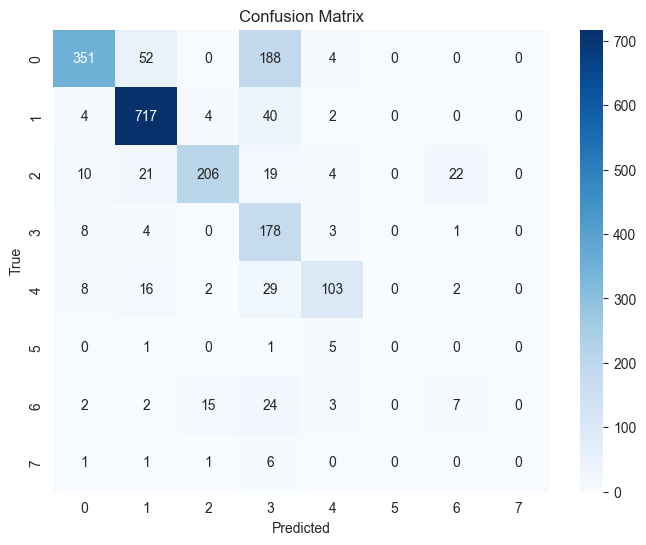

In [12]:
best_params, best_val_loss = random_search_with_logging(train_loader, val_loader, num_trials=5, device=device)

model, test_metrics = run_with_best_params(
    best_params=best_params,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=20,
    device=device
)